In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
from scipy import linalg
from scipy.interpolate import interp1d

In [2]:
## make the fake data
rich_name = 'q180_bg_miscen'

lam = [20, 30, 45, 60, 1000]
z_data = [0.2, 0.35, 0.5, 0.65]
z_sim = [0.3, 0.4, 0.5]

iz = 0

for binning in ['lam', 'abun2']:
    redshift = z_sim[iz]   
    if redshift == 0.3: z_str = '0p300'
    if redshift == 0.4: z_str = '0p400'
    if redshift == 0.5: z_str = '0p500'
    
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_{rich_name}_desy1/'
    # get the radius
    rp_list = np.logspace(np.log10(0.03), np.log10(30), 15+1)
    rpmin_list = rp_list[:-1]
    rpmax_list = rp_list[1:]
    rpmid_list = np.sqrt(rpmin_list*rpmax_list)
    rp_rad = rpmid_list[rpmid_list>0.2]
    
    #### lesing data ####
    DS_data = []
    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_{binning}_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data.extend(np.exp(DS_interp(np.log(rp_rad))))
    DS_data = np.array(DS_data)
    
    
    if binning == 'lam':
        #### counts data ####
        x, x, NC_data = np.loadtxt(data_loc+'abundance.dat',unpack=True)

    np.savetxt(f'data_vector_abacus_summit/counts_{rich_name}_{binning}_z{redshift}.dat', NC_data)
    np.savetxt(f'data_vector_abacus_summit/lensing_{rich_name}_{binning}_z{redshift}.dat', DS_data)

In [3]:
# # check radius!
# rp_rad = np.loadtxt(f'/projects/hywu/cluster_sims/cluster_finding/data/emulator_train/train/rp_rad.dat')
# rp_cov = np.loadtxt(cov_loc + 'rp_hiMpc_0.35_0.5_60_1000.dat')[:,2] * a / h
# print((rp_cov[4:] - rp_rad)/rp_rad) #okay!

frac noise: DS [0.08154109 0.06859154 0.06125334 0.05753082 0.05892046 0.06885746
 0.08155415 0.09132753 0.09525851 0.09919636 0.11034822]
frac noise: DS [0.09073965 0.07349114 0.06320366 0.05762497 0.05658503 0.06397421
 0.07757384 0.091262   0.10186895 0.11164911 0.12630251]
frac noise: DS [0.12615074 0.09832192 0.08240459 0.07309897 0.06935142 0.07536615
 0.09078621 0.11113667 0.12935217 0.14613748 0.16996485]
frac noise: DS [0.10777843 0.08014047 0.06429169 0.05494951 0.0499204  0.05158484
 0.06112847 0.07717867 0.09582731 0.11380733 0.13778066]
frac noise: NC [0.04368221 0.07334801 0.1410353  0.23325707]
frac noise: DS [0.08055169 0.06765957 0.06039862 0.05670253 0.057999   0.06776292
 0.08038178 0.09007042 0.09434432 0.09863678 0.10958077]
frac noise: DS [0.09397493 0.07653477 0.06619017 0.06063912 0.05987274 0.06795704
 0.082256   0.0962008  0.10606741 0.11549607 0.13024045]
frac noise: DS [0.13331923 0.10530209 0.08866582 0.07920501 0.07579353 0.08358026
 0.10117491 0.12333428 

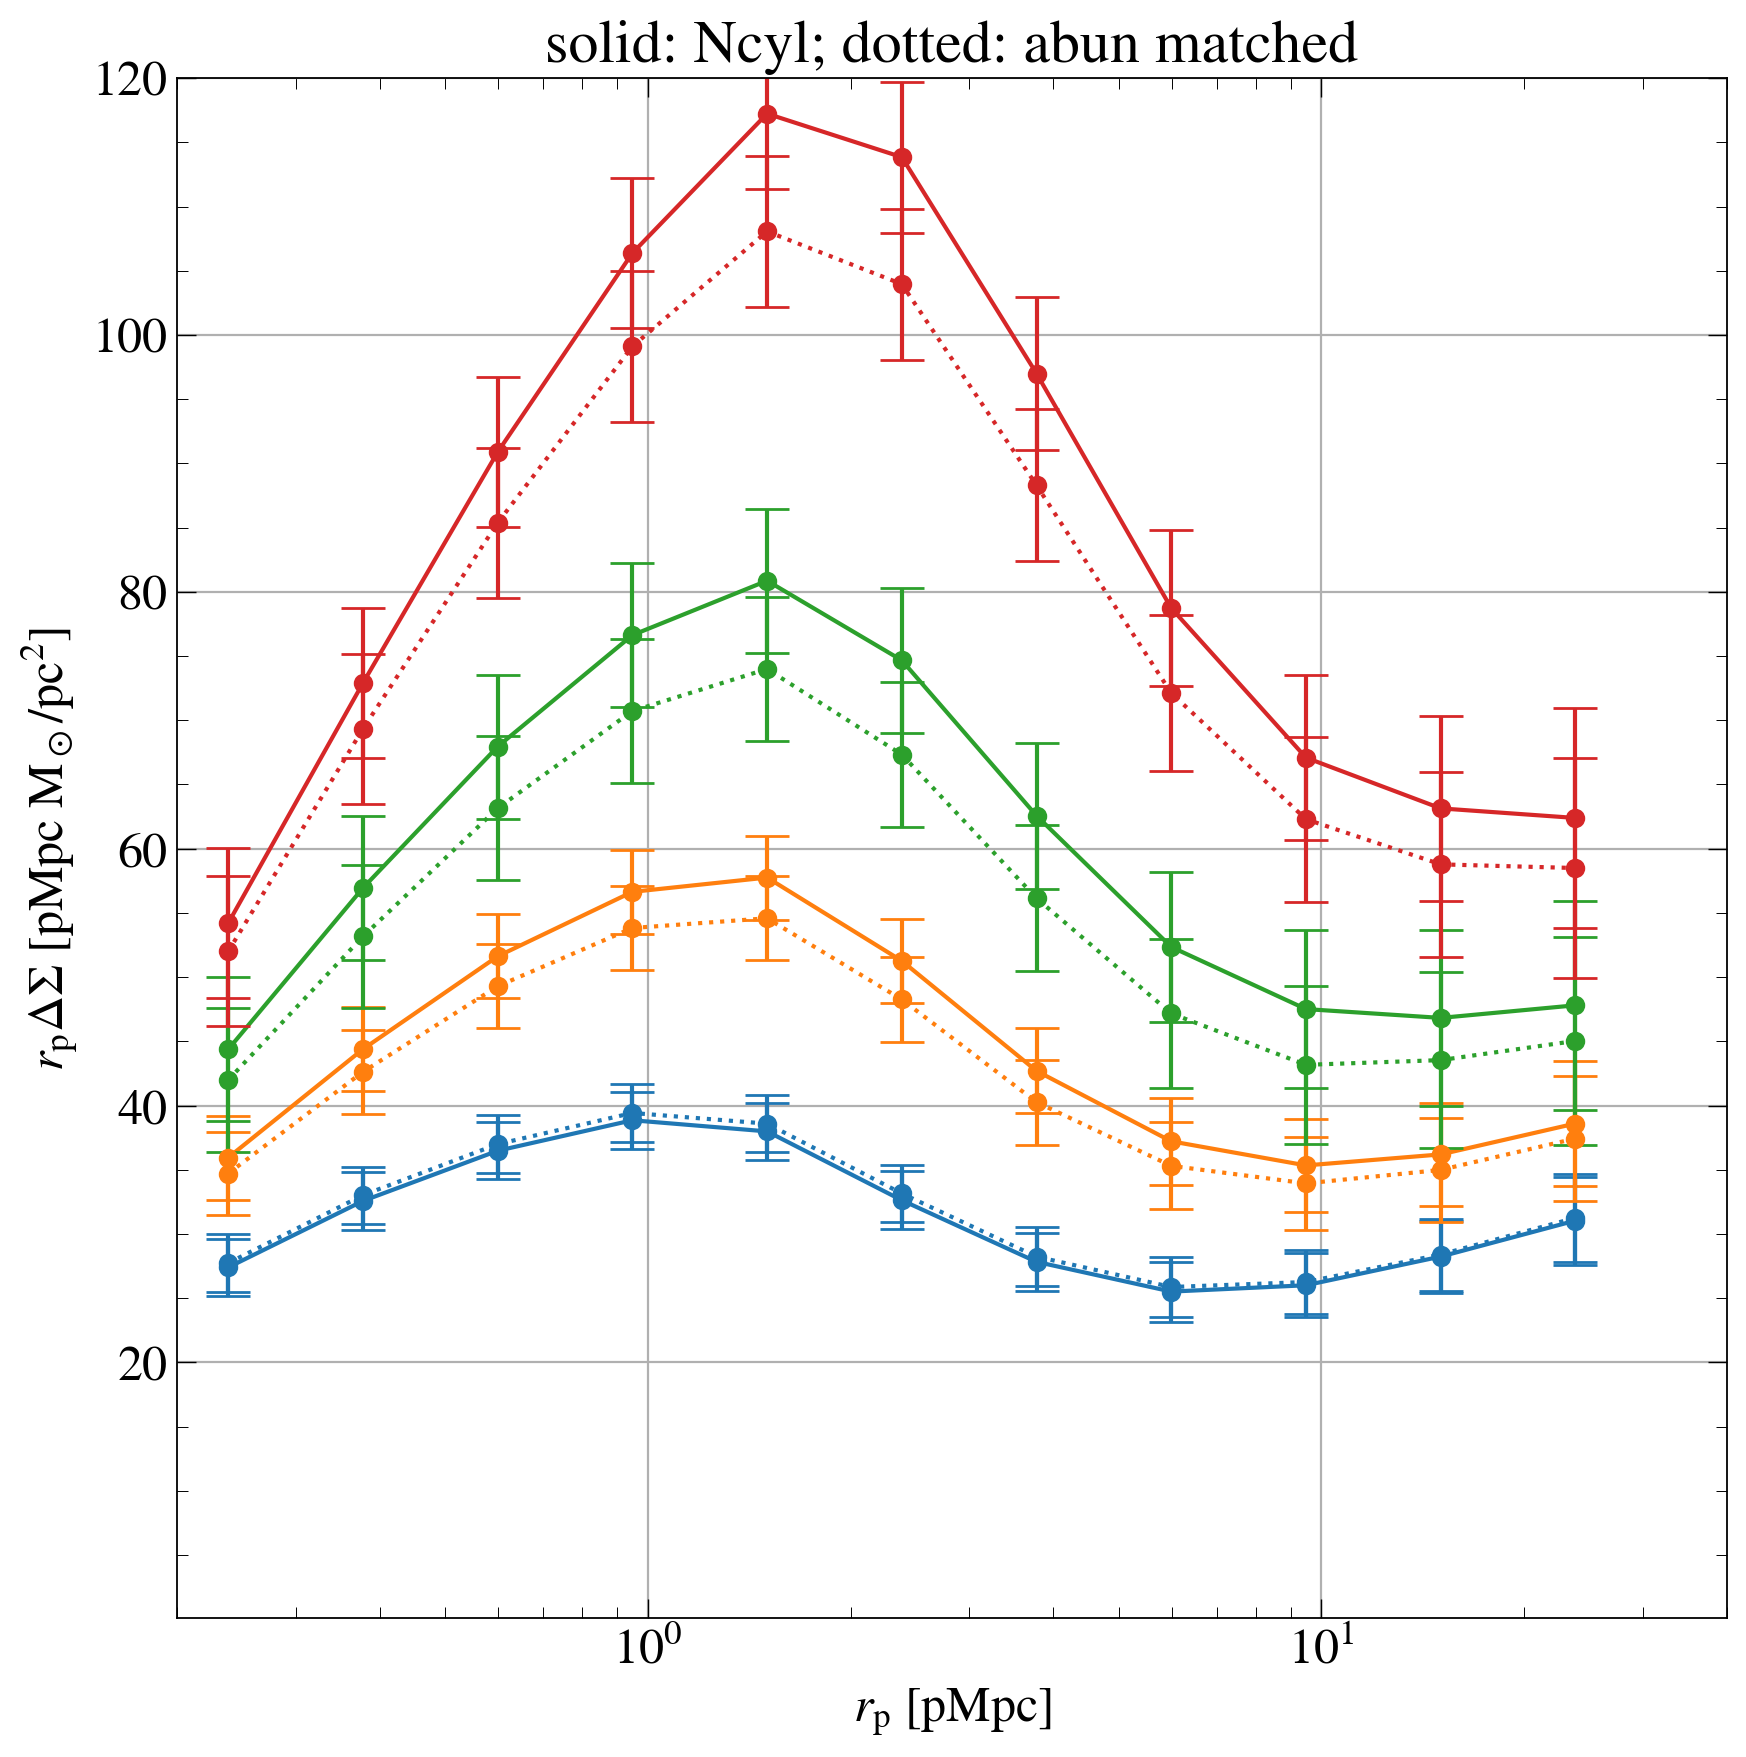

In [8]:
# plot the fake data and error bars
plt.figure(figsize=(10,10))
cov_loc = '/users/hywu/work/cluster-lensing-cov-public/examples/abacus_summit_analytic_desy1/'
#for iz in [0]:#range(3):
    #plt.subplot(1,3,1+iz)
for binning in ['lam', 'abun2']:
    if binning == 'lam': ls = '-'
    if binning == 'abun2': ls = ':'

    redshift = z_sim[iz]
    data_loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/base_c000_ph000/'
    data_loc += f'z{z_str}/model_hod000000/obs_{rich_name}_desy1/'

    for ilam in range(4):
        rp_in, DS_in = np.loadtxt(data_loc + f'DS_phys_noh_{binning}_bin_{ilam}.dat', unpack=True)
        DS_interp = interp1d(np.log(rp_in), np.log(DS_in))
        DS_data = np.exp(DS_interp(np.log(rp_rad)))
    
        cov = np.loadtxt(cov_loc + f'DeltaSigma_cov_combined_phys_noh_{z_data[iz]}_{z_data[iz+1]}_{lam[ilam]}_{lam[ilam+1]}.dat')
        sig = np.sqrt(np.diag(cov))[4:]
        line = plt.plot(rp_rad, rp_rad*DS_data, ls=ls, c=f'C{ilam}')
        co = line[0].get_c()
        plt.errorbar(rp_rad, rp_rad*DS_data, rp_rad*sig, 
                     label='data', c=co, marker='o', mec=co, ls='', capsize=8)#, np.diag(cov))
        plt.xscale('log')
        print('frac noise: DS', sig/DS_data)
    
    plt.xlim(0.2, 40)
    plt.ylim(0.10, 120)
    plt.title(f'AbacusSummit z={redshift}, DES-level noise')
    
    plt.xlabel(r'$r_{\rm p}~[{\rm pMpc}]$')
    plt.ylabel(r'$r_{\rm p} \Delta\Sigma~[{\rm pMpc ~M_\odot/pc^2} ]$')
    cov_NC = np.loadtxt('cov/cov_counts_desy1_z0.3.dat')
    sig_NC = np.sqrt(np.diag(cov_NC))
    print('frac noise: NC',sig_NC/NC_data)
    plt.title('solid: Ncyl; dotted: abun matched')
